# Analysis of Popular Description Words Using Goodreads Data

We wanted to investigate the relationship of words used in the description of various books with factors such as their popularity, their average quality, and how these description words changed over time. Using the Goodreads API to retrieve data on the popularity of books, we visualized common words in descriptions over time, and their relationship to popularity and quality.

Our primary motivation here was twofold. First, we wanted to see if it was possible to extract features of popular and highly rated books from their descriptions, to see if there are certain words or phrases in the description of a book that make it more likely for people to read it or rate it highly. Second, we wanted to see what kind of trends existed in book descriptions over time, and see if we could potentially draw correlations to current events, and see if books being published over time followed any sort of patterns. 

In order to do this, we first collected and processed data on over two hundred thousand books from Goodreads. With this information, we were able to observe trends in popularity and ratings for certain words and phrases in book descriptions, as well as trends in word frequency that reflected events going on in the world at the time. 

### Content

Topics that are covered in this project include:
- Loading data from Goodreads API
- Processing descriptions into meaningful words
- Most common words used in general
- Most common words used, grouped by popularity of the book
- Most common words used, grouped by rating of the book
- Most common words used over time

In [1]:
import time, json
import requests
import csv
from bs4 import BeautifulSoup
import nltk
import string
import pandas as pd
from collections import Counter

## Loading Data From Goodreads API
We first load the data using a private API key from the Goodreads API - generate your own and place it in api_key.txt

In [2]:
def read_api_key(filepath):
    with open(filepath, 'r') as f:
        return f.read().replace('\n','')
    
api_key = read_api_key('api_key.txt')

We then retrieve metadata about a book given its book ID. Metadata includes: Goodreads book id, author, publication date(month/day/year), publisher, review count, rating count, average rating, genre, and description text.

In [3]:
# Get metadata about a book given its book ID
def get_book_metadata(api_key, book_id):
    request_params = {'id':book_id, 'key':api_key, 'format':'xml', 'text_only':'true'}
    response = requests.get('https://www.goodreads.com/book/show', params=request_params)
    
    book_info = {}
    
    book_info['book_id'] = book_id
    
    soup = BeautifulSoup(response.text, 'lxml')

    # Title
    try:
        book_info['title'] = soup.find('original_title').text
    except:
        book_info['title'] = ''
    
    # Author
    try:
        book_info['author'] = soup.find('author').find('name').text
    except:
        book_info['author'] = ''
    
    # Publication date
    try:
        year = soup.find('publication_year').text
        month = soup.find('publication_month').text
        day = soup.find('publication_day').text
        book_info['publication_date'] = str(month) + '/' + str(day) + '/' + str(year)
    except:
        book_info['publication_date'] = ''
        
    # Publisher
    try:
        book_info['publisher'] = soup.find('publisher').text
    except:
        book_info['publisher'] = ''
    
    # Review information
    try:
        book_info['review_count'] = soup.find('text_reviews_count').text
    except:
        book_info['review_count'] = -1
    
    # Rating information
    try:
        book_info['rating_count'] = soup.find('ratings_count').text
    except:
        book_info['rating_count'] = -1
    try:
        book_info['average_rating'] = soup.find('average_rating').text
    except:
        book_info['average_rating'] = -1
    
    # Treat the genre as the most popular shelf this book has been placed on
    try:
        all_shelves = soup.find('popular_shelves').find_all('shelf')
        num_shelves = min(len(all_shelves), 10)
        genres = []
        for i in range(num_shelves):
            genres.append(all_shelves[i]['name'])
        #book_info['genre'] = soup.find('popular_shelves').find('shelf')['name']
        book_info['genre'] = ','.join(genres)
    except:
        book_info['genre'] = ''
    
    # Truncated blurb
    try:
        book_info['description'] = soup.find('description').text.strip()
    except:
        book_info['description'] = ''
    
    return book_info

We downloaded 23 csv files of 10k books each, totaling 230k books.

In [ ]:
# Save all book metadata as a CSV
def download_book_metadata(api_key):
    data_columns = ['book_id', 'title', 'author', 'publication_date', 'publisher', 'review_count', 'rating_count', 'average_rating', 'genre', 'description']
    
    file_index = 1
    book_index = 1
    
    for i in range(23):
        with open('data/metadata' + str(file_index) + '.csv', 'w', encoding='utf-8') as output_file:
            dict_writer = csv.DictWriter(output_file, data_columns, lineterminator='\n')
            dict_writer.writeheader()

            # TODO: iterate through book IDs - add a time.sleep(1) between each iteration
            for i in range(10000):
                current_metadata = get_book_metadata(api_key, book_index)
                dict_writer.writerow(current_metadata)
                book_index += 1

            file_index += 1
        print("Finished file " + str(file_index-1))

download_book_metadata(api_key)

Next, we retrieved information about individual reviews of books, including the score, text of the review, and date the review was written.

In [4]:
# Get all the reviews for a given book ID as a list of dictionaries
# Review data we are collecting - rating, date, and review text
def get_reviews(api_key, book_id):
    request_params = {'id':book_id, 'key':api_key, 'format':'xml', 'text_only':'true'}
    response = requests.get('https://www.goodreads.com/book/show', params=request_params)
    
    try:
        soup = BeautifulSoup(response.text, 'lxml')
        iframe = soup.find('reviews_widget').find('iframe')

        all_reviews = []

        reviews_url = iframe['src']
        response_reviews = requests.get(reviews_url)
    except:
        all_reviews = [{'book_id':'', 'rating':'', 'date':'', 'text':''}]
        return all_reviews
    
    while(1):
        review_soup = BeautifulSoup(response_reviews.text, 'lxml')
        reviews = review_soup.find_all('div', {'class':'gr_review_container'})
        
        for review in reviews:
            current_review = {}

            # Extract the rating
            rating = review.find('span', {'class':'gr_rating'})
            if (rating):
                rating = rating.find_all(text=True)
                rating_num = 0
                for i in range(len(rating[0])):
                    if (ord(rating[0][i]) == 9733):
                        rating_num += 1
            else:
                rating_num = -1

            # Extract the date
            try:
                date = review.find('span', {'class':'gr_review_date'}).find_all(text=True)
                date = [x.strip() for x in date][0]
            except:
                date = ''

            # Extract the review text
            try:
                s = [x.strip() for x in review.find('div', {'class':'gr_review_text'}).find_all(text=True)]
                s = [x for x in s if x]

                # Ignore the last element, the '...more'
                review_text = ' '.join(s[:-1])

                # Remove the last word, since it will be partial
                review_text = ' '.join(review_text.split(' ')[:-1])
            except:
                review_text = ''

            current_review['book_id'] = book_id
            current_review['rating'] = rating_num
            current_review['date'] = date
            current_review['text'] = review_text

            all_reviews.append(current_review)

            #print(current_review)
        
        # See if there is another page of reviews
        if (review_soup.find_all('a', {'class':'next_page'}) != []):
            # There is another page
            reviews_url = 'https://goodreads.com' + review_soup.find('a', {'class':'next_page'})['href']
            response_reviews = requests.get(reviews_url)
        else:
            # No more pages of reviews
            break
        
    return all_reviews

We downloaded 5 csv files of 10k reviews each, totaling in 60k books.

In [ ]:
# Save all reviews as a CSV
def download_reviews(api_key):
    data_columns = ['book_id', 'rating', 'date', 'text']
    
    file_index = 1
    book_index = 1
    
    for i in range(5):
        with open('data/reviews' + str(file_index) + '.csv', 'w', encoding='utf-8') as output_file:
            dict_writer = csv.DictWriter(output_file, data_columns, lineterminator='\n')
            dict_writer.writeheader()

            for j in range(10000):
                current_reviews = get_reviews(api_key, book_index)
                dict_writer.writerows(current_reviews)
                book_index += 1
                time.sleep(0.5)
            
            file_index += 1
        print("Finished file " + str(file_index-1))

book_reviews = get_reviews(api_key, 68428)

## Processing Descriptions Into Meaningful Words

In [5]:
def csv_to_df(path):
    df = pd.read_csv(path)
    df = df[pd.notnull(df['description'])]
    return df

In [6]:
lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
stopwords=nltk.corpus.stopwords.words('english')
words_to_ignore = ['"', "'", 'book', 'author', 'de', 'la', 'wa', '’', '”', 'der', 'à']

We take out some common words like "book" and "author", since those words are not relevant to our analysis, as they occur frequently in almost all book descriptions. In addition, we found some garbage words that did not seem to be proper English, and those were manually excluded as well.

We then lemmatized and tokenized all the words in the description of each book using the natural language processing toolkit. 

In [7]:
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    text = text.lower()
    text = text.replace("'s", "")
    text = text.replace("'", "")
    for char in text: 
        if (char in string.punctuation): text = text.replace(char, " ")
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word, 'v') for word in words]
    filtered_words = [word for word in words if word not in stopwords \
                      and word not in words_to_ignore]
    return filtered_words

def process_all(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    for i, row in df.iterrows():
        original = row['description']
        df.at[i, 'description'] = process(original)
    return df

We will load 23 files of metadata and process them.

In [8]:
df_full = []
for x in range(1,24):
    df = csv_to_df('data/metadata%d.csv'%(x))
    processed = process_all(df)
    df_full.append(processed)

## Most Common Words
We extracted common words from the entire dataset to see what kinds of words are overall used in descriptions of novels. Some of the most common words we found are displayed below.

In [9]:
def popular_words(processed):
    fin = []
    for i, row in processed.iterrows():
        fin.extend(row['description'])
    count = Counter(fin)
    return count

# Function to print counts dictionaries in a more human-readable way
def print_as_table(counts_dict):
    print("{:<15} {:<15}".format("Word", "Count"))
    for k, v in counts_dict:
        print("{:<15} {:<15}".format(k,v))

In [10]:
counter_all = Counter()
for i in range(0,23):
    processed = df_full[i]
    rare = popular_words(processed)
    counter_all += rare

In [11]:
print_as_table(counter_all.most_common(20))

Word            Count          
new             28374          
one             26810          
life            25351          
world           21541          
work            21396          
time            20101          
make            17499          
first           16459          
write           15994          
include         15836          
find            14821          
love            14225          
story           13549          
live            13330          
history         12020          
take            11893          
also            11822          
know            11472          
man             10722          
years           10634          


### Common Words by Popularity
We used the number of ratings that a book received as a measure of its popularity. By visualizing the distribution of the rating count, we decided on bins for popularity to be more densely located at lower rating counts, as there were significantly more books on the low end of the spectrum. The bins we decided on were 0 to 50k, 50k to 100k, 100k to 200k,  200k to 300k,  300k to 400k, 400k to 500k,  500k to 600k, 600k to 700k, 700k to 800k, 800k to 900k, 900k to 1000k, 1000k to 3000k and above 3000k. 

Below is the histogram of rating counts.

In [12]:
import matplotlib.pyplot as plt 
%matplotlib inline

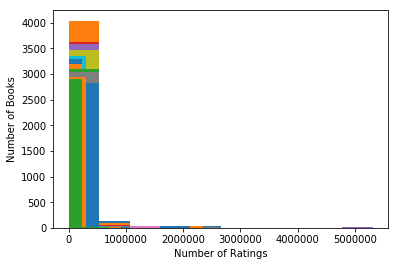

In [13]:
plt.figure()
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Books')
for x in range(1,24):
    df = csv_to_df('data/metadata%d.csv'%(x))
    plt.hist(df['rating_count'])

In [14]:
def popular_words_rc(processed):
    R0_50k, R50k_100k, R100k_200k,  R200k_300k,  R300k_400k, R400k_500k,  R500k_600k, R600k_700k, \
    R700k_800k, R800k_900k, R900k_1000k, R1000k_3000k, R3000kabove \
                = [], [], [], [], [], [], [], [], [], [], [], [], []
    for i, row in processed.iterrows():
        if (0 <= row['rating_count'] < 50000): R0_50k.extend(row['description'])
        elif (50000 <= row['rating_count'] < 100000): R50k_100k.extend(row['description'])
        elif (100000 <= row['rating_count'] < 200000): R100k_200k.extend(row['description'])
        elif (200000 <= row['rating_count'] < 300000): R200k_300k.extend(row['description'])
        elif (300000 <= row['rating_count'] < 400000): R300k_400k.extend(row['description'])
        elif (400000 <= row['rating_count'] < 500000): R400k_500k.extend(row['description'])
        elif (500000 <= row['rating_count'] < 600000): R500k_600k.extend(row['description'])
        elif (600000 <= row['rating_count'] < 700000): R600k_700k.extend(row['description'])
        elif (700000 <= row['rating_count'] < 800000): R700k_800k.extend(row['description'])
        elif (800000 <= row['rating_count'] < 900000): R800k_900k.extend(row['description'])
        elif (900000 <= row['rating_count'] < 1000000): R900k_1000k.extend(row['description'])
        elif (1000000 <= row['rating_count'] < 3000000): R1000k_3000k.extend(row['description'])
        elif (3000000 <= row['rating_count']): R3000kabove.extend(row['description'])
            
    return Counter(R0_50k), Counter(R50k_100k), Counter(R100k_200k), Counter(R200k_300k), Counter(R300k_400k), \
            Counter(R400k_500k), Counter(R500k_600k), Counter(R600k_700k), Counter(R700k_800k), \
            Counter(R800k_900k), Counter(R900k_1000k), Counter(R1000k_3000k), Counter(R3000kabove)

In [15]:
R0_50k, R50k_100k, R100k_200k,  R200k_300k,  R300k_400k, R400k_500k,  R500k_600k, R600k_700k, \
    R700k_800k, R800k_900k, R900k_1000k, R1000k_3000k, R3000kabove \
        = Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), Counter(),\
            Counter(), Counter(), Counter(), Counter()
for x in range(0,23):
    processed = df_full[x]
    a, b, c, d, e, f, g, h, i, j, k, l, m = popular_words_rc(processed)
    R0_50k += a
    R50k_100k += b
    R100k_200k += c
    R200k_300k += d
    R300k_400k += e
    R400k_500k += f
    R500k_600k += g
    R600k_700k += h
    R700k_800k += i
    R800k_900k += j
    R900k_1000k += k
    R1000k_3000k += l
    R3000kabove += m

You can see that books that were extremely popular included words like harry (Harry Potter), gatsby (The Great Gatsby), and kill (To Kill a Mockingbird). In addition, we can see some thematic trends across popularity categories. For example, fantasy-related words seem to have a fairly decent spread of categories, implying that fantasy novels are widely spread in terms of popularity. On the other hand, there are some words that are only found in certain bins and seem to specify certain books or authors, like "dorian" - The Picture of Dorian Gray - implying that these books and authors have a very consistent popularity ranking. Also, it was interesting to see specific author name, such as Tolstoy be some of the most popular words in a bin (500k to 600k).

We have displayed the  most popular words from only some of the categories below to avoid very lengthy outputs.

In [16]:
print("0 to 50k")
print_as_table(R0_50k.most_common(10))
print("-----------------")
print("500k to 600k")
print_as_table(R500k_600k.most_common(10))
print("-----------------")
print("700k to 800k")
print_as_table(R700k_800k.most_common(10))
print("-----------------")
print("1000k to 3000k")
print_as_table(R1000k_3000k.most_common(10))
print("-----------------")
print("3000k and above")
print_as_table(R3000kabove.most_common(10))

0 to 50k
Word            Count          
new             26581          
one             24184          
life            23387          
work            19953          
world           19581          
time            18438          
make            16301          
include         14965          
write           14914          
first           14912          
-----------------
500k to 600k
Word            Count          
story           137            
novel           137            
world           137            
life            136            
one             114            
new             90             
tolstoy         88             
edition         85             
work            73             
live            72             
-----------------
700k to 800k
Word            Count          
dracula         102            
dorian          85             
world           75             
one             69             
age             63             
work            63             
l

### Common Words by Rating

We decided to use the average rating of a book as a metric of its quality. By visualizing the distribution of the rating count, we decide on the bins for quality to be: 0 to 1, 1 to 2, 2 to 2.5, 2.5 to 3, 3 to 3.3, 3.3 to 3.6, 3.6 to 3.9, 3.9 to 4.2, 4.2 to 4.5 and 4.5 to 5.0

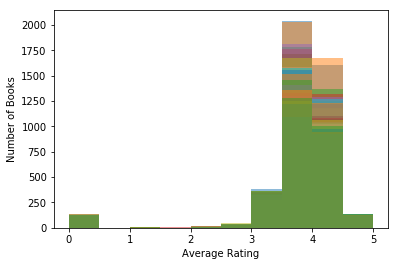

In [17]:
plt.figure()
plt.xlabel('Average Rating')
plt.ylabel('Number of Books')
for x in range(1,24):
    df = csv_to_df('data/metadata%d.csv'%(x))
    plt.hist(df['average_rating'], alpha=0.5)

In [18]:
def popular_words_rating(processed):
    zero, one, two, two2, three1, three2, three3, four1, four2 = \
    [], [], [], [], [], [], [], [], []
    for i, row in processed.iterrows():
        if (0 <= round(row['average_rating'], 1) < 1.0): zero.extend(row['description'])
        elif (1 <= round(row['average_rating'], 1) < 2.0): one.extend(row['description'])
        elif (2.0 <= round(row['average_rating'], 1) < 2.5): two.extend(row['description'])
        elif (2.5 <= round(row['average_rating'], 1) < 3.0): two2.extend(row['description'])
        elif (3.0 <= round(row['average_rating'], 1) < 3.3): three1.extend(row['description'])
        elif (3.3 <= round(row['average_rating'], 1) < 3.6): three2.extend(row['description'])
        elif (3.6 <= round(row['average_rating'], 1) < 3.9): three3.extend(row['description'])
        elif (4.2 <= round(row['average_rating'], 1) < 4.5): four1.extend(row['description'])
        elif (4.5 <= round(row['average_rating'], 1) < 5.0): four2.extend(row['description'])
    return Counter(zero), Counter(one), Counter(two), Counter(two2), Counter(three1), \
            Counter(three2), Counter(three3), Counter(four1), Counter(four2)

In [19]:
zero, one, two, two2, three1, three2, three3, four1, four2 = \
    Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), Counter()
for x in range(0,23):
    processed = df_full[x]
    a, b, c, d, e, f, g, h, i= popular_words_rating(processed)
    zero += a
    one += b
    two += c
    two2 += d
    three1 += e
    three2 += f
    three3 += g
    four1 += h
    four2 += i

Similar to popularity, we can see trends with phrases and genres throughout the rating categories. In particular, once again, fantasy terms seem relatively spread out across various rating categories. In addition, we can see some types of books like study guides and self-help books show up in the lower rating categories (with words like "study" and "write"), implying people generally don't like these kinds of books. We have displayed the common words for each rating category.

In [20]:
print("rating 0.0 to 1.0 :   " + str(zero.most_common(20)) + "\n")
print("rating 1.0 to 2.0 :   " + str(one.most_common(10)) + "\n")
print("rating 2.0 to 2.5 :   " + str(two.most_common(10)) +"\n")
print("rating 2.5 to 3.0 :   " + str(two2.most_common(20)) + "\n")
print("rating 3.0 to 3.3:   " + str(three1.most_common(20)) + "\n")
print("rating 3.3 to 3.6 :   " + str(three2.most_common(20)) + "\n")
print("rating 3.6 to 3.9:   " + str(three3.most_common(20)) + "\n")
print("rating 4.2 to 4.5 :   " + str(four1.most_common(20)) + "\n")
print("rating 4.5 to 5.0 :   " + str(four2.most_common(20)) + "\n")

rating 0.0 to 1.0 :   [('work', 894), ('include', 705), ('new', 679), ('study', 586), ('use', 525), ('provide', 500), ('also', 476), ('write', 467), ('make', 425), ('one', 424), ('first', 412), ('life', 403), ('world', 387), ('present', 378), ('volume', 371), ('well', 346), ('time', 345), ('state', 317), ('history', 316), ('find', 308)]

rating 1.0 to 2.0 :   [('use', 45), ('include', 31), ('work', 29), ('new', 24), ('write', 22), ('students', 22), ('find', 20), ('also', 20), ('provide', 20), ('make', 20)]

rating 2.0 to 2.5 :   [('new', 101), ('work', 94), ('include', 76), ('one', 69), ('write', 68), ('study', 65), ('life', 61), ('use', 56), ('make', 55), ('read', 54)]

rating 2.5 to 3.0 :   [('new', 247), ('life', 234), ('one', 217), ('make', 195), ('work', 191), ('include', 172), ('world', 170), ('time', 165), ('use', 132), ('live', 128), ('write', 127), ('love', 125), ('first', 124), ('find', 119), ('also', 115), ('take', 114), ('get', 111), ('help', 108), ('women', 108), ('history

### Common Words Over Time

We will load deta frames again and this time, get rid of all books with no publication data and ignore month and date of publication

In [21]:
df_time = []
for x in range(1,24):
    df = csv_to_df('data/metadata%d.csv'%(x))
    df = df[df.publication_date != '//']
    df["publication_date"] = df["publication_date"].apply(lambda x: x[-4:])
    processed = process_all(df)
    df_time.append(processed)

In [22]:
def popular_words_time(processed):
    t1900, t1950, t1960, t1970, t1980, t1990, t1995, t2000, t2002, t2005, t2007, t2010, t2012, t2015, t2020 = \
    [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
    
    for i, row in processed.iterrows():
        if (0 < int(row['publication_date']) <= 1900): t1900.extend(row['description'])
        elif (1900 < int(row['publication_date']) <= 1950): t1950.extend(row['description'])
        elif (1950 < int(row['publication_date']) <= 1960): t1960.extend(row['description'])
        elif (1960 < int(row['publication_date']) <= 1970): t1970.extend(row['description'])
        elif (1970 < int(row['publication_date']) <= 1980): t1980.extend(row['description'])
        elif (1980 < int(row['publication_date']) <= 1990): t1990.extend(row['description'])
        elif (1990 < int(row['publication_date']) <= 1995): t1995.extend(row['description'])
        elif (1995 < int(row['publication_date']) <= 2000): t2000.extend(row['description'])
        elif (2000 < int(row['publication_date']) <= 2002): t2002.extend(row['description'])
        elif (2002 < int(row['publication_date']) <= 2005): t2005.extend(row['description'])
        elif (2005 < int(row['publication_date']) <= 2007): t2007.extend(row['description'])
        elif (2007 < int(row['publication_date']) <= 2010): t2010.extend(row['description'])
        elif (2010 < int(row['publication_date']) <= 2012): t2012.extend(row['description'])
        elif (2012 < int(row['publication_date']) <= 2015): t2015.extend(row['description'])
        elif (2015 < int(row['publication_date']) <= 2020): t2020.extend(row['description'])
        
    return Counter(t1900), Counter(t1950), Counter(t1960), Counter(t1970), Counter(t1980), \
        Counter(t1990), Counter(t1995), Counter(t2000), Counter(t2002), Counter(t2005), Counter(t2007), \
        Counter(t2010), Counter(t2012), Counter(t2015), Counter(t2020)

In [23]:
t1900,t1950, t1960, t1970, t1980, t1990, t1995, t2000, t2002, t2005, t2007, t2010, t2012, t2015, t2020 \
        = Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), \
            Counter(), Counter(), Counter(), Counter() , Counter(), Counter(), Counter()
for x in range(0, 23):
    processed = df_time[x]
    b, c, d, e, f, g, h, i, j, k, l, m, n, o, p = popular_words_time(processed)
    t1900 +=b 
    t1950 +=c
    t1960 += d
    t1970 += e
    t1980 += f 
    t1990 += g
    t1995 += h
    t2000 += i 
    t2002 += j
    t2005 += k 
    t2007 += l
    t2010 += m
    t2012 += n
    t2015 += o
    t2020 += p

The results were especially interesting to see for this section. پوریا, which is one of the most frequent words used in 1800-1900 bin, is a male given name in Persia. Other than that, we also see bible being one of common words. 
Word such as family, is one of consistent theme across all dates.

In [24]:
# print("1800 and below :   " + str(t1800.most_common(30)) + "\n")
print("1800-1900 :   " + str(t1900.most_common(30)) + "\n")
print("1900-1950 :   " + str(t1950.most_common(30)) + "\n")
print("1950-1960 :   " + str(t1960.most_common(30)) + "\n")
print("1960-1970 :   " + str(t1970.most_common(30)) + "\n")
print("1970-1980 :   " + str(t1980.most_common(30)) + "\n")
print("1980-1990 :   " + str(t1990.most_common(30)) + "\n")
print("1990-1995 :   " + str(t1995.most_common(30)) + "\n")
print("1995-2000 :   " + str(t2000.most_common(30)) + "\n")
print("2000-2002 :   " + str(t2002.most_common(30)) + "\n")
print("2002 - 2005 :   " + str(t2005.most_common(30)) + "\n")
print("2005 - 2007 :   " + str(t2007.most_common(30)) + "\n")
print("2005 - 2010 :   " + str(t2010.most_common(30)) + "\n")
print("2010 - 2012 :   " + str(t2012.most_common(30)) + "\n")
print("2012 - 2015 :   " + str(t2015.most_common(30)) + "\n")
print("2015 - 2020 :   " + str(t2020.most_common(30)) + "\n")

1800-1900 :   [('می', 18), ('و', 18), ('به', 14), ('را', 13), ('که', 12), ('در', 10), ('او', 9), ('پوریا', 8), ('برای', 8), ('از', 8), ('home', 7), ('bible', 6), ('soseki', 6), ('با', 6), ('feng', 6), ('shui', 6), ('use', 5), ('well', 5), ('make', 5), ('work', 5), ('art', 5), ('نام', 5), ('ی', 5), ('سرزمین', 5), ('اما', 5), ('قصه', 5), ('form', 4), ('also', 4), ('time', 4), ('follow', 4)]

1900-1950 :   [('work', 69), ('edition', 55), ('first', 53), ('life', 48), ('one', 47), ('story', 45), ('write', 38), ('new', 34), ('library', 30), ('make', 29), ('history', 28), ('part', 28), ('loeb', 27), ('volumes', 27), ('roman', 26), ('years', 26), ('publish', 25), ('great', 25), ('cover', 25), ('classical', 24), ('man', 24), ('novel', 23), ('also', 22), ('three', 20), ('ce', 20), ('world', 20), ('know', 20), ('war', 19), ('survive', 19), ('little', 19)]

1950-1960 :   [('one', 74), ('work', 64), ('life', 58), ('write', 55), ('story', 54), ('world', 49), ('new', 48), ('·', 48), ('man', 43), ('lo

We visualized the proportion of a few common words' use in book descriptions over time.

It is interesting to see specific names like Kurt Vonnegut appear very frequently in 1960-1970. Also, one thing to notice is the popularity of the word 'war' starting in 1980 and becoming increasingly popular after that, potentially relating to the spike in war-related publications due to the Vietnam War.

In [27]:
time_periods = [t1900, t1950, t1960, t1970, t1980, t1990, t2000, t2002, t2005, t2007, t2010, t2012, t2015, t2020]
labels = ['<1900', '<1950', '<1960', '<1970', '<1980', '<1990', '<2000', '<2002', '<2005', '<2007', '<2010', \
          '<2012', '<2015', '<2020']
def visualize_word(labels, bins, word):
    word_dict = {}
    for i in range(len(bins)):
        counter = bins[i]
        label = labels[i]
        word_dict[label] = counter[word] / (sum(counter.values())) * 100
        
    plt.figure()
    plt.xlabel('Year')
    plt.ylabel('Proportion of Word')
    plt.bar(list(word_dict.keys()), word_dict.values(), color='g')
    plt.xticks(rotation=90)
    plt.title(word)
    plt.show()

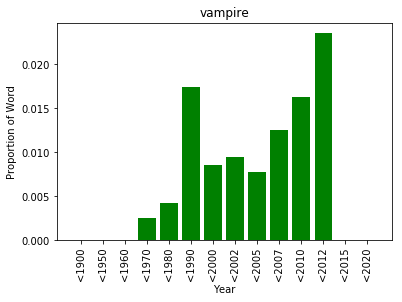

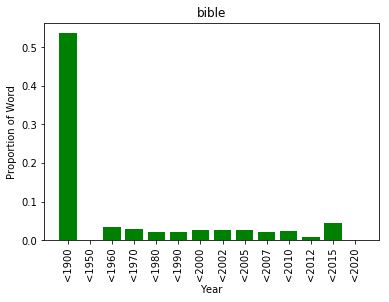

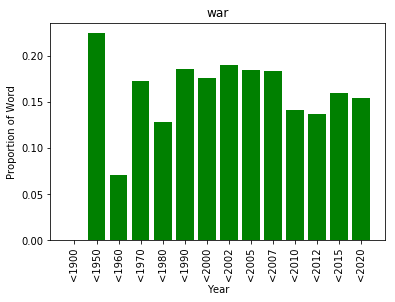

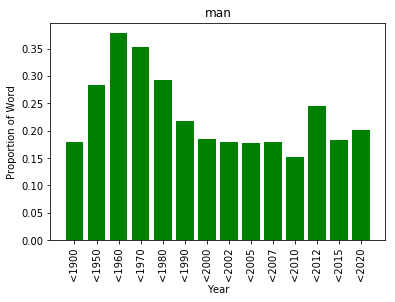

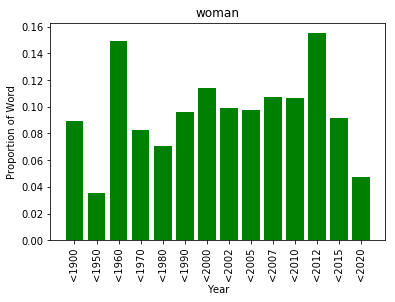

In [28]:
visualize_word(labels, time_periods, 'vampire')
visualize_word(labels, time_periods, 'bible')
visualize_word(labels, time_periods, 'war')
visualize_word(labels, time_periods, 'man')
visualize_word(labels, time_periods, 'woman')

Some interesting things to note are the timings of spikes and increases in these graphs. For example, "woman" had a spike in the 60s, around the time of the second feminist movement. "vampire" had a spike in the '90s due to the Dracula movie being published, resulting in a surge of related novels, and another spike around 2008 with the publication of the Twilight series. "war" had the most interesting results, as the use of the word "war" in publications very closely reflects global conflicts and current events trends. 

# Conclusions and Further Work
Overall, we believe that the descriptions in novels have a lot to say about what readers are interested in at any given time, and can also serve as a window into the current events landscape of the time. 

This data can be used to inform authors of what "works" or doesn't work in terms of getting their books to be more popular. In addition, it can be used to analyze what readers overall are looking for in books, and what trending topics or genres seem to be at any given time. 

Some further work that we would perform on this dataset would be analyzing reviews over time, and seeing how books' popularity changes over time. It would be interesting to see if surges of popularity (more people reading and reviewing a given book) correlated with current events, in addition to the correlations we found with publications of those books. 

# References
[Goodreads API](https://www.goodreads.com/api)